In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# from keras import backend as K`
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
from tensorflow.keras.backend import ctc_batch_cost
import tensorflow.keras.backend as K
from IPython.display import Image, display
import matplotlib as mpl
from keras.models import load_model
import json

In [2]:
IMG_HEIGHT, IMG_WIDTH = 64, 256
BATCH_SIZE = 120

def get_new_label(label):
    label_list=[]
    for i in range(len(label)):
        label_list.append(alphabet_dict[label[i]])
    
    return label_list
    
# Function to parse CSV and return filenames and labels
def parse_data(csv_file, image_dir, alphabet_dict,length=None):
    df = pd.read_csv(csv_file)
    if length:
        df = df.loc[:length,:]
    df.dropna(axis=0,inplace=True)
    df = df[df["IDENTITY"]!="UNREADABLE"]
    df.reset_index(inplace = True, drop = True)
    
    df["IDENTITY"] = df["IDENTITY"].str.upper()
    image_paths = image_dir + df["FILENAME"]
    labels = np.ones([len(df),34]) * (-1)
    for i in range(len(df)):
        labels[i,0:len(df.iat[i,1])] = np.array(get_new_label(df.iat[i,1]))
    label_lens = [len(df.iat[i,1]) for i in range(len(df))]
    return image_paths, labels, label_lens

# Function to generate tf.data.Dataset
def create_dataset(image_paths, labels, label_lens, pred_len):
    # Create TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels, label_lens))
    
    def process_data(image_path, label, label_len):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=1, expand_animations=False)
        original_height = tf.shape(image)[0]
        original_width = tf.shape(image)[1]
        req_height=64
        req_width=256
        # Crop if the image is larger than the target size
        image = tf.image.crop_to_bounding_box(
            image, offset_height=0, offset_width=0,
            target_height=tf.minimum(req_height, original_height),
            target_width=tf.minimum(req_width, original_width)
        )
        
        # Get new dimensions after cropping
        cropped_height = tf.shape(image)[0]
        cropped_width = tf.shape(image)[1]
        
        # Calculate how much padding is needed
        pad_height = req_height - cropped_height
        pad_width = req_width - cropped_width
        
        # Pad the image manually with 255 (white) if it's smaller than the target size
        if pad_height > 0 or pad_width > 0:
            image = tf.pad(image, paddings=[[0, pad_height], [0, pad_width], [0, 0]], constant_values=255)
    
        # Normalize the image after resizing (padding with 255 ensures white background)

        # image = tf.image.crop_to_bounding_box(image, offset_height=0, offset_width=0, target_height=IMG_HEIGHT, target_width=IMG_WIDTH)
        image = tf.image.rot90(image, k=3)  # Rotate 90 degrees clockwise
        image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]

        pred_len = tf.constant(62, dtype=tf.float32)
        return (image, label, pred_len, label_len), tf.constant(0.0)
    
    dataset = dataset.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset
    
alphabet_dict = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 
                 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 
                 'Y': 24, 'Z': 25, '-': 26, "'": 27, "`": 27, " ": 28}

# Paths to CSV and directories
train_csv = '/kaggle/input/handwriting-recognition/written_name_train_v2.csv'
train_img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'
val_csv = '/kaggle/input/handwriting-recognition/written_name_validation_v2.csv'
val_img_dir = '/kaggle/input/handwriting-recognition/validation_v2/validation/'
test_csv = '/kaggle/input/handwriting-recognition/written_name_test_v2.csv'
test_img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/'

# Parse CSVs to get paths and labels
train_paths, train_labels, train_label_lens = parse_data(train_csv, train_img_dir, alphabet_dict)
val_paths, val_labels, val_label_lens = parse_data(val_csv, val_img_dir, alphabet_dict)
test_paths, test_labels, test_label_lens = parse_data(test_csv, test_img_dir, alphabet_dict)
# Create datasets
train_ds = create_dataset(train_paths, train_labels, train_label_lens, pred_len=62)
val_ds = create_dataset(val_paths, val_labels, val_label_lens, pred_len=62)
test_ds = create_dataset(test_paths, test_labels, test_label_lens, pred_len=62)

In [3]:
input_data = Input(shape=(256, 64, 1), name='input')
# input_data = Input(shape=(64, 256, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)


# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1',)(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(30, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 256, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 256, 64, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max1 (MaxPooling2D)             │ (None, 128, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 128, 32, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 32, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2 (MaxPooling2D)             │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64, 64)         │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm1 (Bidirectional)           │ (None, 64, 512)        │       657,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (Bidirectional)           │ (None, 64, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64, 30)         │        15,390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 64, 30)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,332,510 (8.90 MB)

 Trainable params: 2,332,318 (8.90 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/25


2025-11-22 01:03:13.112007: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_3_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2753/2753 ━━━━━━━━━━━━━━━━━━━━ 686s 246ms/step - accuracy: 3.9719e-06 - loss: 22.7068 - val_accuracy: 0.0037 - val_loss: 6.8986
Epoch 2/25
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 435s 158ms/step - accuracy: 0.0431 - loss: 5.7227 - val_accuracy: 0.3071 - val_loss: 3.0937
Epoch 3/25
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 435s 158ms/step - accuracy: 0.3023 - loss: 3.0986 - val_accuracy: 0.5113 - val_loss: 2.2979
Epoch 4/25
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 434s 157ms/step - accuracy: 0.4617 - loss: 2.4312 - val_accuracy: 0.5937 - val_loss: 1.9944
Epoch 5/25
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 435s 158ms/step - accuracy: 0.5449 - loss: 2.1193 - val_accuracy: 0.6388 - val_loss: 1.8308
Epoch 6/25
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 435s 158ms/step - accuracy: 0.5974 - loss: 1.9204 - val_accuracy: 0.6660 - val_loss: 1.7138
Epoch 7/25
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 436s 158ms/step - accuracy: 0.6304 - loss: 1.7866 - val_accuracy: 0.6798 - val_loss: 1.6423
Epoch 8/25
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 436s 158ms/step - accuracy

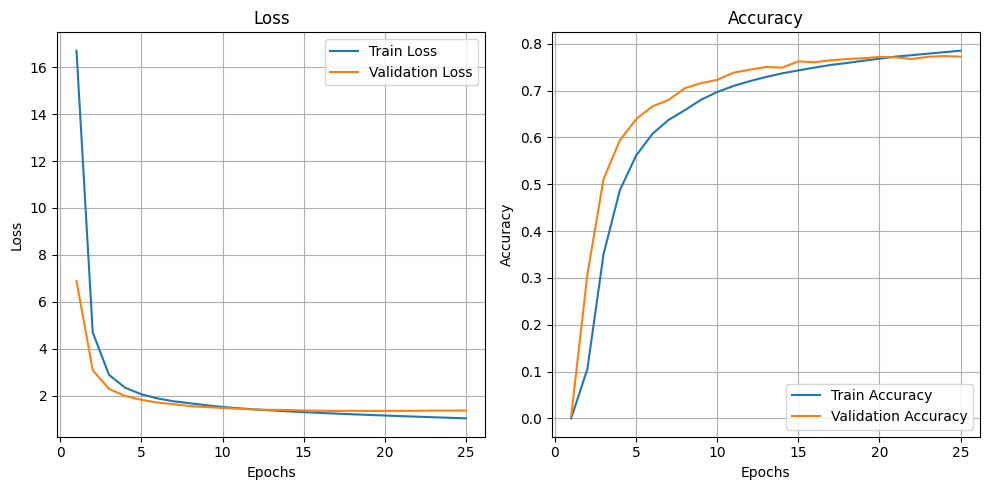

In [4]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return ctc_batch_cost(labels, y_pred, input_length, label_length)

from keras.layers import Input
from keras.models import Model
# new_input = Input(shape=(new_height, new_width, channels), name='new_input')
labels = Input(name='gtruth_labels', shape=[34], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')


ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001),metrics=["accuracy"])
history=model_final.fit(train_ds, validation_data=val_ds, epochs=25)

print(history.history.keys())
epoch_axis = range(1, 26)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_axis,history.history['loss'], label='Train Loss')
plt.plot(epoch_axis,history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epoch_axis,history.history['accuracy'], label='Train Accuracy')
plt.plot(epoch_axis,history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()

model.save('handwriting_model.h5')
model_final.save('trainingmodel.h5')
with open('training_history.txt', 'w') as file:
    json.dump(history.history, file)

In [5]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret
    
val_prediction = []

for (image, label, pred_len, label_len),_ in val_ds:
    preds = model.predict(image)
    decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], greedy=True)[0][0])
    
    for i in range(len(decoded)):
        val_prediction.append(num_to_label(decoded[i]))

df = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_validation_v2.csv')
df.dropna(axis=0,inplace=True)
df = df[df["IDENTITY"]!="UNREADABLE"]
df.reset_index(inplace = True, drop = True)

df["IDENTITY"] = df["IDENTITY"].str.upper()
y_true = df.loc[:, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(len(y_true)):
    pr = val_prediction[i].strip()
    tr = y_true[i].strip()
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/len(y_true)))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━

In [6]:
    
test_prediction = []

for (image, label, pred_len, label_len),_ in test_ds:
    preds = model.predict(image)
    decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], greedy=True)[0][0])
    
    for i in range(len(decoded)):
        test_prediction.append(num_to_label(decoded[i]))


df = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')
df.dropna(axis=0,inplace=True)
df = df[df["IDENTITY"]!="UNREADABLE"]
df.reset_index(inplace = True, drop = True)

df["IDENTITY"] = df["IDENTITY"].str.upper()
y_true = df.loc[:, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(len(y_true)):
    pr = test_prediction[i].strip()
    tr = y_true[i].strip()
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/len(y_true)))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━

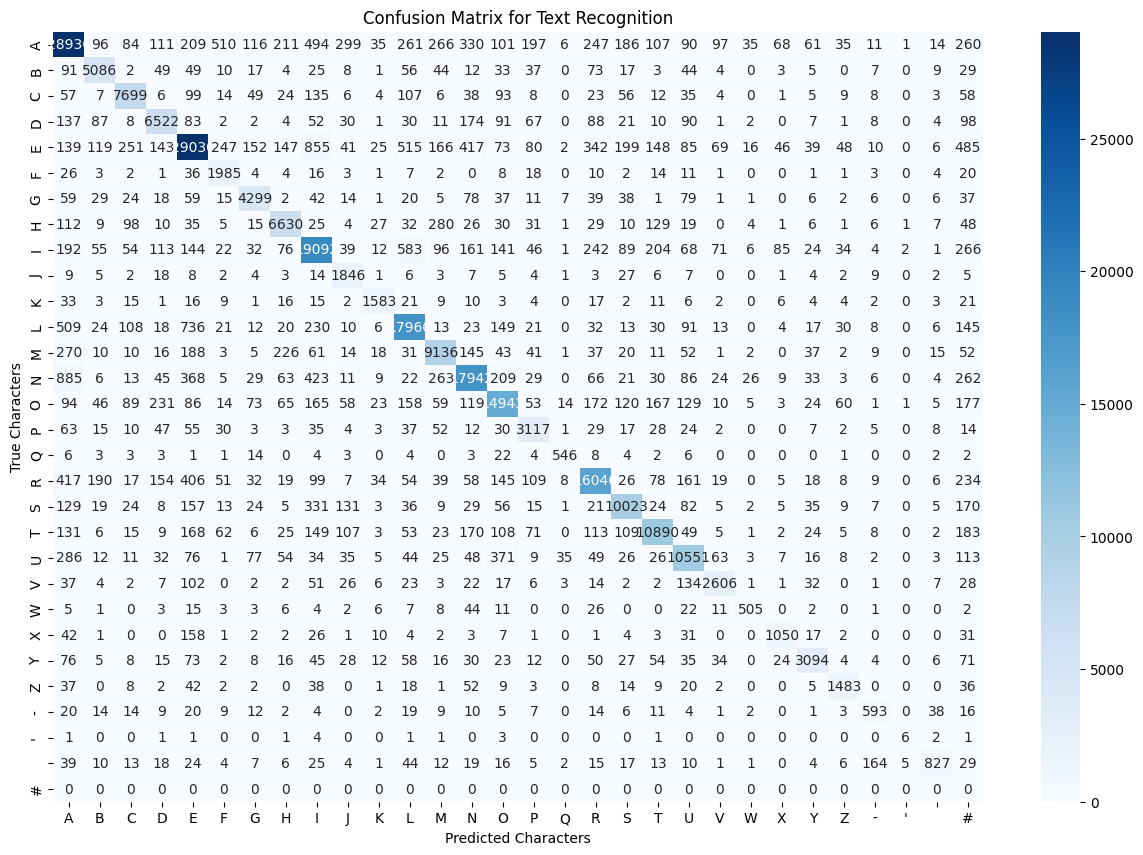

              precision    recall  f1-score   support

           A       0.88      0.86      0.87     33474
           B       0.87      0.89      0.88      5718
           C       0.90      0.90      0.90      8566
           D       0.86      0.85      0.86      7631
           E       0.89      0.86      0.88     33895
           F       0.65      0.91      0.76      2183
           G       0.86      0.87      0.87      4936
           H       0.87      0.87      0.87      7631
           I       0.85      0.87      0.86     21955
           J       0.68      0.92      0.78      2004
           K       0.86      0.87      0.87      1819
           L       0.89      0.89      0.89     20249
           M       0.87      0.87      0.87     10456
           N       0.90      0.86      0.88     20892
           O       0.89      0.87      0.88     17164
           P       0.78      0.85      0.81      3653
           Q       0.87      0.85      0.86       642
           R       0.90    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' #" 
num_classes = len(alphabets)
char_to_idx = {char: idx for idx, char in enumerate(alphabets)}

def adjust_length(pred, true, pad_char="#"):
    if len(pred) > len(true):
        return pred[:len(true)], true  # Truncate prediction
    elif len(pred) < len(true):
        return pred + pad_char * (len(true) - len(pred)), true  # Pad prediction
    return pred, true  # Already same length
y_pred_flat = []
y_true_flat = []

for pred, true in zip(test_prediction, y_true):
    adjusted_pred, adjusted_true = adjust_length(pred, true)
    y_pred_flat.extend([char_to_idx[c] for c in adjusted_pred if c in char_to_idx])
    y_true_flat.extend([char_to_idx[c] for c in adjusted_true if c in char_to_idx])

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat, labels=list(range(num_classes)))

# Plot the confusion matrix
plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=alphabets, yticklabels=alphabets)
plt.xlabel("Predicted Characters")
plt.ylabel("True Characters")
plt.title("Confusion Matrix for Text Recognition")
plt.show()

print(classification_report(y_true_flat, y_pred_flat, target_names=list(alphabets)))
